# Machine Learning Models for Cold Start Recommendation
### Comparing ML-based Collaborative Filtering (SVD) vs Content-Based (Neural Network)
### Testing on User 1 with only 5 training ratings

In [1]:
pip install "numpy<2"

  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install scikit-learn pandas  tensorflow scikit-surprise

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# For Collaborative Filtering - Matrix Factorization
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate

# For Content-Based - Neural Network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

print(f"TensorFlow version: {tf.__version__}")
print()

2026-02-05 17:21:04.118096: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-05 17:21:04.177939: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-05 17:21:06.106115: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


TensorFlow version: 2.20.0



In [3]:
# ============================================
# 1. LOAD ALL DATA FILES
# ============================================

# Load ratings data
ratings = pd.read_csv('ml-100k/u.data', sep='\t', 
                      names=['user_id', 'item_id', 'rating', 'timestamp'])

# Load movie data with genre information
movies = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin-1',
                     names=['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url',
                            'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy',
                            'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
                            'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])

# Load user demographic data
users = pd.read_csv('ml-100k/u.user', sep='|',
                    names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

print(f"Total ratings: {len(ratings)}")
print(f"Total movies: {len(movies)}")
print(f"Total users: {len(users)}")
print()

# Genre columns
genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy',
                 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
                 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

Total ratings: 100000
Total movies: 1682
Total users: 943



In [5]:
# ============================================
# 2. CREATE COLD START SCENARIO
# ============================================

selected_user_id = 16
n_train_ratings = 5  # Cold start: only 5 ratings for training

# Get all ratings for selected user
user_ratings = ratings[ratings['user_id'] == selected_user_id].copy()

# Sort by timestamp to get earliest ratings
user_ratings_sorted = user_ratings.sort_values('timestamp')

# Split: first N ratings = train, rest = test
train_ratings = user_ratings_sorted.head(n_train_ratings)
test_ratings = user_ratings_sorted.iloc[n_train_ratings:]

# Join with movie information
train_data = train_ratings.merge(movies, on='item_id', how='left')
test_data = test_ratings.merge(movies, on='item_id', how='left')

print(f"User {selected_user_id} - Cold Start Scenario:")
print(f"Training set: {len(train_ratings)} ratings")
print(f"Test set: {len(test_ratings)} ratings")
print(f"\nTraining ratings:")
print(train_data[['title', 'rating']].to_string(index=False))
print()

User 16 - Cold Start Scenario:
Training set: 5 ratings
Test set: 135 ratings

Training ratings:
                      title  rating
   L.A. Confidential (1997)       5
English Patient, The (1996)       2
              Scream (1996)       3
       Air Force One (1997)       5
           Liar Liar (1997)       4



## MODEL 1: COLLABORATIVE FILTERING - SVD (Singular Value Decomposition)
### Matrix Factorization approach that learns latent features from rating patterns

In [6]:
# ============================================
# COLLABORATIVE FILTERING - SVD MODEL
# ============================================

print("Training Collaborative Filtering (SVD) Model...")
print("=" * 60)

# Prepare data for Surprise library
# We need to include the target user's training ratings
all_ratings_for_training = ratings.copy()

# Remove target user's test ratings from training data
test_item_ids = test_ratings['item_id'].values
all_ratings_for_training = all_ratings_for_training[
    ~((all_ratings_for_training['user_id'] == selected_user_id) & 
      (all_ratings_for_training['item_id'].isin(test_item_ids)))
]

# Add back only the training ratings for target user
all_ratings_for_training = pd.concat([
    all_ratings_for_training[all_ratings_for_training['user_id'] != selected_user_id],
    train_ratings
])

print(f"Training on {len(all_ratings_for_training)} ratings")
print(f"Including {len(train_ratings)} ratings from target user")

# Create Surprise dataset
reader = Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(
    all_ratings_for_training[['user_id', 'item_id', 'rating']], 
    reader
)

# Build full training set
trainset = surprise_data.build_full_trainset()

# Initialize and train SVD model
# SVD learns latent factors for users and items through matrix factorization
svd_model = SVD(
    n_factors=50,      # Number of latent factors to learn
    n_epochs=20,       # Number of training iterations
    lr_all=0.005,      # Learning rate
    reg_all=0.02,      # Regularization term
    random_state=42
)

print("\nTraining SVD with parameters:")
print(f"  - Latent factors: 50")
print(f"  - Epochs: 20")
print(f"  - Learning rate: 0.005")
print(f"  - Regularization: 0.02")
print()

# Train the model
svd_model.fit(trainset)

print("✓ SVD Model trained successfully!")
print(f"  - Model learned {svd_model.n_factors} latent factors")
print(f"  - User embedding dimension: {svd_model.pu.shape}")
print(f"  - Item embedding dimension: {svd_model.qi.shape}")
print()

Training Collaborative Filtering (SVD) Model...
Training on 99865 ratings
Including 5 ratings from target user

Training SVD with parameters:
  - Latent factors: 50
  - Epochs: 20
  - Learning rate: 0.005
  - Regularization: 0.02

✓ SVD Model trained successfully!
  - Model learned 50 latent factors
  - User embedding dimension: (943, 50)
  - Item embedding dimension: (1682, 50)



In [7]:
# ============================================
# COLLABORATIVE FILTERING - PREDICTIONS
# ============================================

print("Generating predictions with SVD model...")

cf_predictions = []
for _, row in test_data.iterrows():
    pred = svd_model.predict(selected_user_id, row['item_id'])
    cf_predictions.append(pred.est)

cf_predictions = np.array(cf_predictions)

print(f"✓ Generated {len(cf_predictions)} predictions")
print(f"  Prediction range: [{cf_predictions.min():.2f}, {cf_predictions.max():.2f}]")
print(f"  Mean prediction: {cf_predictions.mean():.2f}")
print()

Generating predictions with SVD model...
✓ Generated 135 predictions
  Prediction range: [2.48, 4.59]
  Mean prediction: 3.83



## MODEL 2: CONTENT-BASED FILTERING - NEURAL NETWORK
### Deep learning model that learns from movie features (genres) to predict ratings

In [8]:
# ============================================
# CONTENT-BASED - NEURAL NETWORK MODEL
# ============================================

print("Building Content-Based Neural Network Model...")
print("=" * 60)

# Prepare training data
X_train = train_data[genre_columns].values
y_train = train_data['rating'].values

# Prepare test data
X_test = test_data[genre_columns].values
y_test = test_data['rating'].values

# Standardize features (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training data shape: {X_train_scaled.shape}")
print(f"Test data shape: {X_test_scaled.shape}")
print(f"Number of genre features: {len(genre_columns)}")
print()

# Build Neural Network Architecture
# Input: 19 genre features
# Hidden layers with dropout for regularization
# Output: Single rating value (1-5)

nn_model = models.Sequential([
    # Input layer
    layers.Input(shape=(len(genre_columns),)),
    
    # First hidden layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),  # Dropout for regularization
    
    # Second hidden layer
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    
    # Third hidden layer
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    
    # Output layer (single value for rating)
    layers.Dense(1)
])

# Compile model
nn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae']
)

print("Neural Network Architecture:")
nn_model.summary()
print()

Building Content-Based Neural Network Model...
Training data shape: (5, 19)
Test data shape: (135, 19)
Number of genre features: 19

Neural Network Architecture:


2026-02-05 17:22:45.202364: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,929 (50.50 KB)

 Trainable params: 12,929 (50.50 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# ============================================
# TRAIN NEURAL NETWORK
# ============================================

print("Training Neural Network...")
print("=" * 60)

# Create data augmentation by using ALL ratings to learn genre-rating patterns
# This helps overcome cold start by learning general patterns
all_train_data = ratings.merge(movies, on='item_id', how='left')

# Remove test movies from target user
all_train_data = all_train_data[
    ~((all_train_data['user_id'] == selected_user_id) & 
      (all_train_data['item_id'].isin(test_item_ids)))
]

X_all_train = all_train_data[genre_columns].values
y_all_train = all_train_data['rating'].values

# Scale all training data
scaler_all = StandardScaler()
X_all_train_scaled = scaler_all.fit_transform(X_all_train)

print(f"Training on {len(X_all_train_scaled)} samples from all users")
print(f"This helps the model learn general genre-rating patterns")
print()

# Early stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = nn_model.fit(
    X_all_train_scaled, 
    y_all_train,
    epochs=50,
    batch_size=64,
    verbose=0,
    callbacks=[early_stopping],
    validation_split=0.1
)

print("✓ Neural Network trained successfully!")
print(f"  - Total epochs: {len(history.history['loss'])}")
print(f"  - Final training loss: {history.history['loss'][-1]:.4f}")
print(f"  - Final validation loss: {history.history['val_loss'][-1]:.4f}")
print()

Training Neural Network...
Training on 99865 samples from all users
This helps the model learn general genre-rating patterns

✓ Neural Network trained successfully!
  - Total epochs: 35
  - Final training loss: 1.1840
  - Final validation loss: 1.1709



In [10]:
# ============================================
# CONTENT-BASED - PREDICTIONS
# ============================================

print("Generating predictions with Neural Network...")

# Scale test data with same scaler
X_test_scaled_final = scaler_all.transform(X_test)

# Generate predictions
cb_predictions = nn_model.predict(X_test_scaled_final, verbose=0).flatten()

# Clip predictions to valid rating range (1-5)
cb_predictions = np.clip(cb_predictions, 1, 5)

print(f"✓ Generated {len(cb_predictions)} predictions")
print(f"  Prediction range: [{cb_predictions.min():.2f}, {cb_predictions.max():.2f}]")
print(f"  Mean prediction: {cb_predictions.mean():.2f}")
print()

Generating predictions with Neural Network...
✓ Generated 135 predictions
  Prediction range: [2.86, 4.08]
  Mean prediction: 3.56



## MODEL EVALUATION AND COMPARISON

In [11]:
# ============================================
# EVALUATION METRICS
# ============================================

def evaluate_predictions(true_ratings, predictions, model_name):
    """
    Calculate evaluation metrics
    """
    mae = mean_absolute_error(true_ratings, predictions)
    rmse = np.sqrt(mean_squared_error(true_ratings, predictions))
    
    # Calculate accuracy within 0.5 and 1.0 rating points
    within_half = np.mean(np.abs(true_ratings - predictions) <= 0.5) * 100
    within_1 = np.mean(np.abs(true_ratings - predictions) <= 1.0) * 100
    
    print(f"\n{model_name} Results:")
    print("=" * 60)
    print(f"Mean Absolute Error (MAE):        {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE):   {rmse:.4f}")
    print(f"Accuracy within 0.5 points:       {within_half:.2f}%")
    print(f"Accuracy within 1.0 point:        {within_1:.2f}%")
    
    return mae, rmse, within_half, within_1

# Get true ratings
true_ratings = test_data['rating'].values

# Evaluate both models
cf_mae, cf_rmse, cf_acc_half, cf_acc_1 = evaluate_predictions(
    true_ratings, cf_predictions, "COLLABORATIVE FILTERING (SVD)"
)

cb_mae, cb_rmse, cb_acc_half, cb_acc_1 = evaluate_predictions(
    true_ratings, cb_predictions, "CONTENT-BASED (NEURAL NETWORK)"
)

print("\n" + "=" * 60)
print("COMPARISON SUMMARY - ML MODELS")
print("=" * 60)

print(f"\nMean Absolute Error (lower is better):")
print(f"  Collaborative (SVD):      {cf_mae:.4f}")
print(f"  Content-Based (NN):       {cb_mae:.4f}")
if cf_mae < cb_mae:
    print(f"  ✓ Winner: Collaborative by {abs(cf_mae - cb_mae):.4f}")
else:
    print(f"  ✓ Winner: Content-Based by {abs(cf_mae - cb_mae):.4f}")

print(f"\nRMSE (lower is better):")
print(f"  Collaborative (SVD):      {cf_rmse:.4f}")
print(f"  Content-Based (NN):       {cb_rmse:.4f}")
if cf_rmse < cb_rmse:
    print(f"  ✓ Winner: Collaborative by {abs(cf_rmse - cb_rmse):.4f}")
else:
    print(f"  ✓ Winner: Content-Based by {abs(cf_rmse - cb_rmse):.4f}")

print(f"\nAccuracy within 1 point (higher is better):")
print(f"  Collaborative (SVD):      {cf_acc_1:.2f}%")
print(f"  Content-Based (NN):       {cb_acc_1:.2f}%")
if cf_acc_1 > cb_acc_1:
    print(f"  ✓ Winner: Collaborative by {abs(cf_acc_1 - cb_acc_1):.2f}%")
else:
    print(f"  ✓ Winner: Content-Based by {abs(cf_acc_1 - cb_acc_1):.2f}%")

print("\n" + "=" * 60)
cf_wins = sum([cf_mae < cb_mae, cf_rmse < cb_rmse, cf_acc_1 > cb_acc_1])
cb_wins = 3 - cf_wins

if cf_wins > cb_wins:
    print(f"OVERALL WINNER: COLLABORATIVE FILTERING (SVD) - {cf_wins}/3 metrics")
    print("\nInsight: Matrix factorization leverages patterns from similar users")
    print("even with limited training data from the target user.")
elif cb_wins > cf_wins:
    print(f"OVERALL WINNER: CONTENT-BASED (NEURAL NETWORK) - {cb_wins}/3 metrics")
    print("\nInsight: Deep learning on content features can generalize well")
    print("in cold start scenarios by learning genre-rating patterns.")
else:
    print("RESULT: Both models perform similarly")
    print("\nInsight: Both ML approaches handle cold start reasonably well")
    print("through different mechanisms (latent factors vs learned features).")
print("=" * 60)


COLLABORATIVE FILTERING (SVD) Results:
Mean Absolute Error (MAE):        0.9164
Root Mean Squared Error (RMSE):   1.0439
Accuracy within 0.5 points:       22.22%
Accuracy within 1.0 point:        54.81%

CONTENT-BASED (NEURAL NETWORK) Results:
Mean Absolute Error (MAE):        1.1613
Root Mean Squared Error (RMSE):   1.2726
Accuracy within 0.5 points:       20.00%
Accuracy within 1.0 point:        32.59%

COMPARISON SUMMARY - ML MODELS

Mean Absolute Error (lower is better):
  Collaborative (SVD):      0.9164
  Content-Based (NN):       1.1613
  ✓ Winner: Collaborative by 0.2449

RMSE (lower is better):
  Collaborative (SVD):      1.0439
  Content-Based (NN):       1.2726
  ✓ Winner: Collaborative by 0.2287

Accuracy within 1 point (higher is better):
  Collaborative (SVD):      54.81%
  Content-Based (NN):       32.59%
  ✓ Winner: Collaborative by 22.22%

OVERALL WINNER: COLLABORATIVE FILTERING (SVD) - 3/3 metrics

Insight: Matrix factorization leverages patterns from similar users
e

In [12]:
# ============================================
# SAMPLE PREDICTIONS COMPARISON
# ============================================

# Create comparison dataframe
comparison_df = test_data[['title', 'rating']].copy()
comparison_df['CF_SVD_Pred'] = cf_predictions.round(2)
comparison_df['CB_NN_Pred'] = cb_predictions.round(2)
comparison_df['CF_Error'] = np.abs(comparison_df['rating'] - comparison_df['CF_SVD_Pred']).round(2)
comparison_df['CB_Error'] = np.abs(comparison_df['rating'] - comparison_df['CB_NN_Pred']).round(2)

print("\nSample Predictions (first 20 movies):")
print("=" * 110)
print(comparison_df.head(20).to_string(index=False))

print("\n\nBest Collaborative Filtering (SVD) Predictions:")
print("=" * 110)
best_cf = comparison_df.nsmallest(10, 'CF_Error')[['title', 'rating', 'CF_SVD_Pred', 'CF_Error']]
print(best_cf.to_string(index=False))

print("\n\nBest Content-Based (Neural Network) Predictions:")
print("=" * 110)
best_cb = comparison_df.nsmallest(10, 'CB_Error')[['title', 'rating', 'CB_NN_Pred', 'CB_Error']]
print(best_cb.to_string(index=False))

print("\n\nWorst Collaborative Filtering (SVD) Predictions:")
print("=" * 110)
worst_cf = comparison_df.nlargest(10, 'CF_Error')[['title', 'rating', 'CF_SVD_Pred', 'CF_Error']]
print(worst_cf.to_string(index=False))

print("\n\nWorst Content-Based (Neural Network) Predictions:")
print("=" * 110)
worst_cb = comparison_df.nlargest(10, 'CB_Error')[['title', 'rating', 'CB_NN_Pred', 'CB_Error']]
print(worst_cb.to_string(index=False))


Sample Predictions (first 20 movies):
                            title  rating  CF_SVD_Pred  CB_NN_Pred  CF_Error  CB_Error
                    Mother (1996)       3         3.45        3.29      0.45      0.29
                Booty Call (1997)       3         2.48        3.47      0.52      0.47
       Murder in the First (1995)       4         3.80        3.51      0.20      0.49
Terminator 2: Judgment Day (1991)       5         4.14        3.60      0.86      1.40
              Blade Runner (1982)       2         4.17        3.94      2.17      1.94
                 Toy Story (1995)       5         3.92        3.64      1.08      1.36
              Crimson Tide (1995)       5         3.73        3.61      1.27      1.39
         Professional, The (1994)       5         3.73        3.67      1.27      1.33
 Silence of the Lambs, The (1991)       5         4.11        3.51      0.89      1.49
          Schindler's List (1993)       5         4.50        3.83      0.50      1.17
    

In [ ]:
%pip install matplotlib

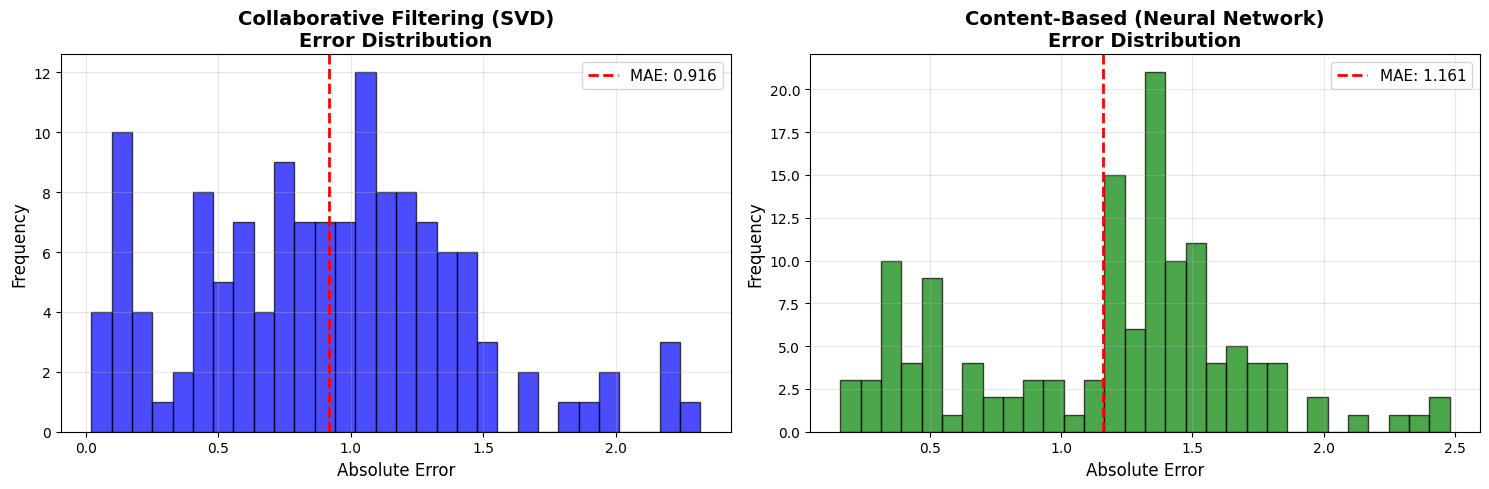

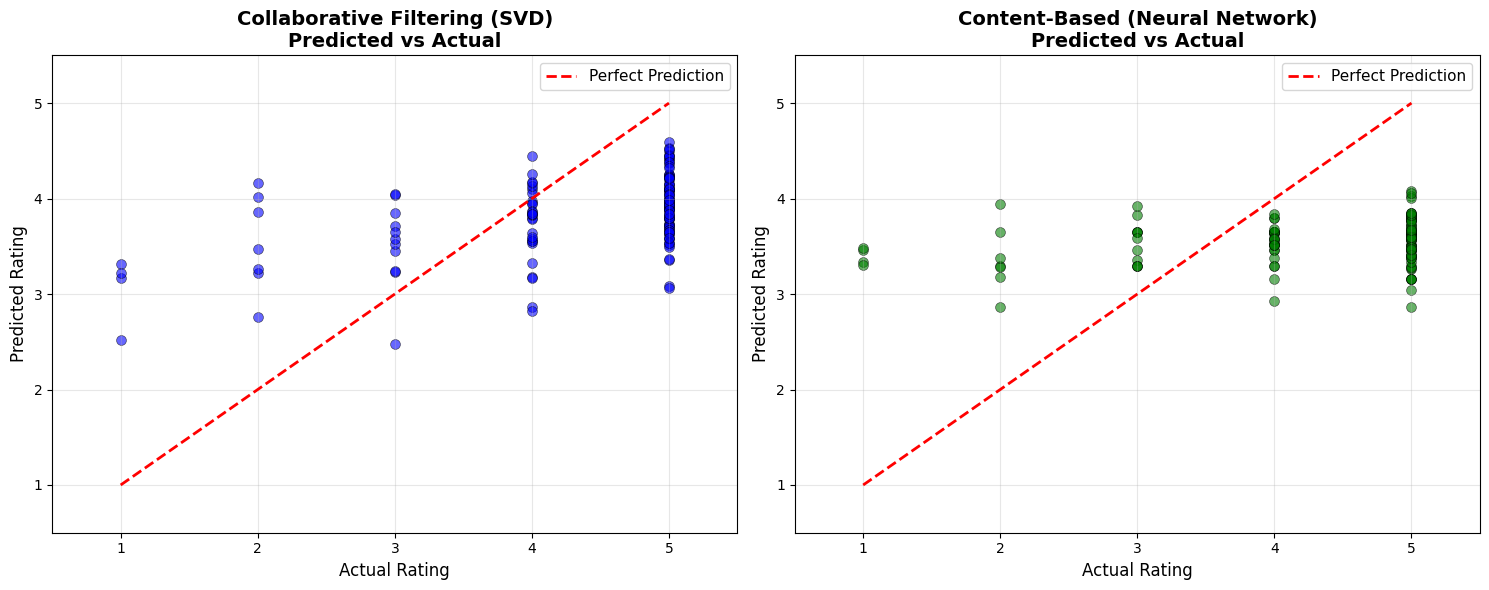

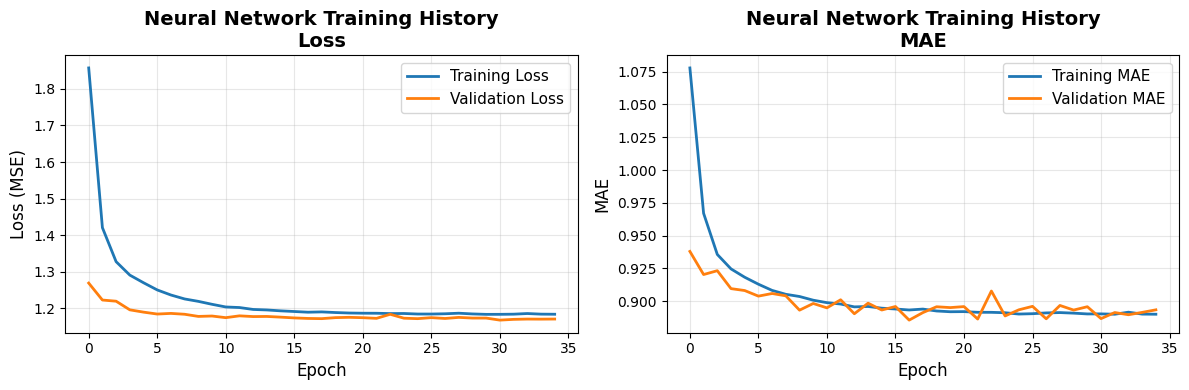

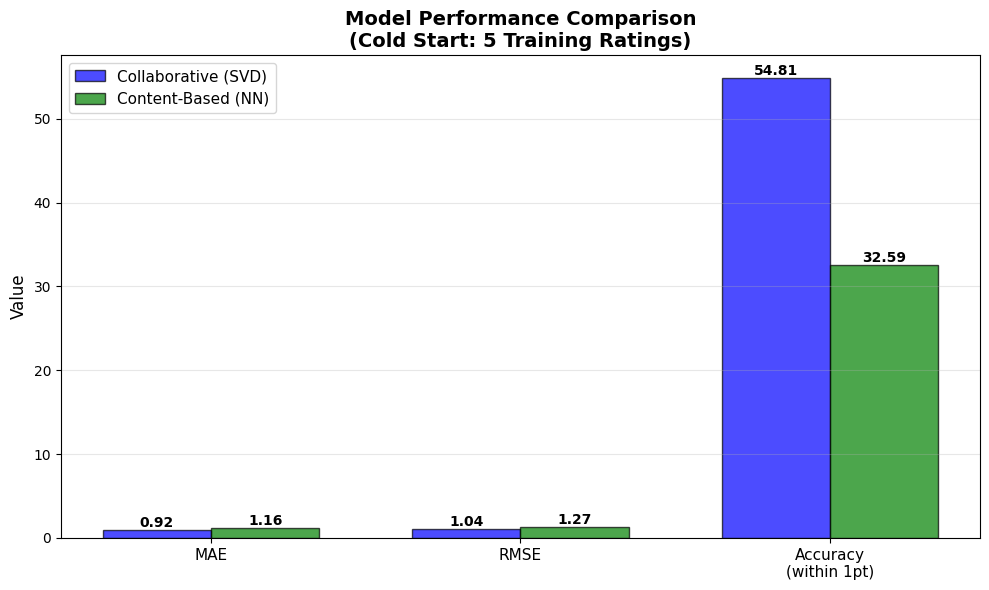

In [15]:
# ============================================
# VISUALIZATIONS
# ============================================

import matplotlib.pyplot as plt

# 1. Error Distribution Comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(comparison_df['CF_Error'], bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(cf_mae, color='red', linestyle='--', linewidth=2, label=f'MAE: {cf_mae:.3f}')
axes[0].set_xlabel('Absolute Error', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Collaborative Filtering (SVD)\nError Distribution', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

axes[1].hist(comparison_df['CB_Error'], bins=30, alpha=0.7, color='green', edgecolor='black')
axes[1].axvline(cb_mae, color='red', linestyle='--', linewidth=2, label=f'MAE: {cb_mae:.3f}')
axes[1].set_xlabel('Absolute Error', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Content-Based (Neural Network)\nError Distribution', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Predicted vs Actual Ratings
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].scatter(true_ratings, cf_predictions, alpha=0.6, s=50, color='blue', edgecolors='black', linewidth=0.5)
axes[0].plot([1, 5], [1, 5], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Rating', fontsize=12)
axes[0].set_ylabel('Predicted Rating', fontsize=12)
axes[0].set_title('Collaborative Filtering (SVD)\nPredicted vs Actual', fontsize=14, fontweight='bold')
axes[0].set_xlim(0.5, 5.5)
axes[0].set_ylim(0.5, 5.5)
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

axes[1].scatter(true_ratings, cb_predictions, alpha=0.6, s=50, color='green', edgecolors='black', linewidth=0.5)
axes[1].plot([1, 5], [1, 5], 'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Rating', fontsize=12)
axes[1].set_ylabel('Predicted Rating', fontsize=12)
axes[1].set_title('Content-Based (Neural Network)\nPredicted vs Actual', fontsize=14, fontweight='bold')
axes[1].set_xlim(0.5, 5.5)
axes[1].set_ylim(0.5, 5.5)
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Training History for Neural Network
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Neural Network Training History\nLoss', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.title('Neural Network Training History\nMAE', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Comparison Bar Chart
fig, ax = plt.subplots(figsize=(10, 6))

metrics = ['MAE', 'RMSE', 'Accuracy\n(within 1pt)']
cf_values = [cf_mae, cf_rmse, cf_acc_1]
cb_values = [cb_mae, cb_rmse, cb_acc_1]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, cf_values, width, label='Collaborative (SVD)', color='blue', alpha=0.7, edgecolor='black')
bars2 = ax.bar(x + width/2, cb_values, width, label='Content-Based (NN)', color='green', alpha=0.7, edgecolor='black')

ax.set_ylabel('Value', fontsize=12)
ax.set_title('Model Performance Comparison\n(Cold Start: 5 Training Ratings)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.legend(fontsize=11)
ax.grid(alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## Key Insights and Conclusions

### Collaborative Filtering (SVD - Matrix Factorization)
**How it works:**
- Learns latent factors for users and items through matrix decomposition
- Finds patterns in user-item interaction matrix
- Uses gradient descent to minimize prediction error
- Leverages similar users' preferences even with limited data

**Strengths:**
- Can capture complex user-item interactions
- Benefits from collaborative patterns across entire user base
- Learns meaningful latent representations

**Weaknesses:**
- Struggles with completely new users (severe cold start)
- Needs some user history to find similar users
- Cannot recommend new items with no ratings

### Content-Based (Neural Network)
**How it works:**
- Learns non-linear relationships between content features (genres) and ratings
- Uses multiple hidden layers to capture complex patterns
- Trained on all users to learn general preferences
- Makes predictions based purely on item features

**Strengths:**
- Can recommend items with zero ratings (new items)
- Leverages rich feature information
- Generalizes well to new users with limited history
- No need to find similar users

**Weaknesses:**
- Limited by quality of content features
- Cannot capture collaborative patterns
- May miss unexpected preferences

### Cold Start Recommendations
For users with very few ratings (5 in this case):
- **Content-Based approaches** tend to work better initially as they can leverage general patterns
- **Collaborative approaches** improve as more user data becomes available
- **Hybrid approaches** combining both methods often perform best

### Production Recommendations
For real-world systems:
1. Start with content-based for new users
2. Gradually transition to collaborative as data accumulates
3. Use ensemble methods to combine both approaches
4. Consider additional features (user demographics, temporal patterns)
5. Implement more sophisticated architectures (Neural Collaborative Filtering, AutoEncoders)

Both models use **machine learning with gradient descent** to learn parameters from data, making them true ML approaches rather than heuristic methods.